In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
import os
from pathlib import Path

cwd = Path(os.getcwd())
train_data = cwd / 'Data' / 'TrainProcessed.csv'
test_data = cwd / 'Data' / 'TestProcessed.csv'

train_df = pd.read_csv(train_data,sep=',')
test_df = pd.read_csv(test_data,sep=',')

In [2]:
test_df = test_df[test_df['src_url'].isin(train_df['src_url'].values) == False]
test_df['Split'] = 'Test'
train_df['Split'] = 'Train'

In [3]:
df = pd.concat([test_df, train_df], axis=0)
df.reset_index(inplace=True)

# Cleaning Data

We'll do another pass-through to clean the text up a bit.

Note that most of these regular-expressions were found by a mixture of manual inspection and trial-and-error using the code chunks contained below (i.e. word clouds, etc)

In [4]:
# A number of regex terms to remove known noisey elements (i.e. from markdown, etc)
df['Text'].replace(to_replace=r'\[[^\n]*\]',value=' ',regex=True, inplace=True)
df['Text'].replace(to_replace=r'\\\* [\w]* \*\\',value=' ',regex=True, inplace=True)
df['Text'].replace(to_replace=r'\/\* [\w]* \*\/',value=' ',regex=True, inplace=True)
df['Text'].replace(to_replace=r'.[\w]* ',value=' ',regex=True, inplace=True)
df['Text'].replace(to_replace=r'\\ [\w ]* ',value=' ',regex=True, inplace=True)
df['Text'].replace(to_replace='\_', value=' ',regex=True, inplace=True)
df['Text'].replace(to_replace='font', value=' ', regex=True, inplace=True)
df['Text'].replace(to_replace=r'pdf', value=' ', regex=True, inplace=True)
df['Text'].replace(to_replace=r'PDF', value='', regex=True, inplace=True)
df['Text'].replace(to_replace=r'Â', value=' ', regex=True, inplace=True)
df['Text'].replace(to_replace=r'â', value=' ', regex=True, inplace=True)
df['Text'].replace(to_replace=r'[^\w]z[^\w]', value=' ', regex=True ,inplace=True)
df['Text'].replace(to_replace=r'[^\w]Z[^\w]', value=' ', regex=True, inplace=True)

In [5]:
ua_df = df.loc[df["sub"] == "UnearthedArcana"]
ua_df.groupby(by='Split').agg('count')

,index,sub,flair,title,Text,src_url
Split,,,,,,
Test,314,314,314,314,314,314
Train,795,795,795,795,795,795


In [6]:
ua_df.groupby(by=['Split','flair']).agg('count')

index  sub  title  Text  src_url
Split flair                                       
Test  Background      1    1      1     1        1
      Class          52   52     52    52       52
      Compendium      7    7      7     7        7
      Feat            2    2      2     2        2
      Feature         2    2      2     2        2
      Item           16   16     16    16       16
      Mechanic        3    3      3     3        3
      Monster        18   18     18    18       18
      Official        9    9      9     9        9
      Other           2    2      2     2        2
      Race           22   22     22    22       22
      Spell          17   17     17    17       17
      Subclass      163  163    163   163      163
Train Background      3    3      3     3        3
      Class         137  137    137   137      137
      Compendium     24   24     24    24       24
      Feat           21   21     21    21       21
      Feature         5    5      5     5        5
      Item           58   58     58    58       58
      Mechanic       29   29     29    29       29
      Monster        55   55     55    55       55
      Official        8    8      8     8        8
      Other           4    4      4     4        4
      Prestige        1    1      1     1        1
      Race           86   86     86    86       86
      Resource        2    2      2     2        2
      Spell          61   61     61    61       61
      Subclass      300  300    300   300      300
      World           1    1      1     1        1

In [7]:
num_duplicates = len(ua_df)-len(ua_df.drop_duplicates(subset=["src_url"]))
if num_duplicates == 0:
    print("No duplicates")
else:
    print(f"{num_duplicates} duplicates found.")

No duplicates


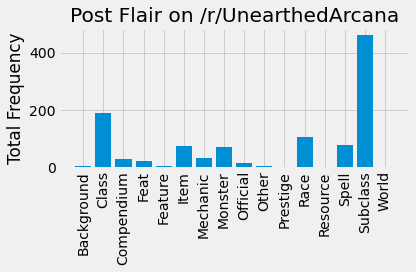

In [8]:
flair_labels, flair_counts = np.unique(ua_df["flair"].values, return_counts=True)
plt.figure(0)
plt.bar(flair_labels, flair_counts)
plt.title("Post Flair on /r/UnearthedArcana")
plt.ylabel("Total Frequency")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("ua_flair_frequency_bar.png")

Based on the above figure, I'm chosing to initially only work with the following flair categories: Class, Item, Monster, Race, Spell, Subclass, and combined Feats/Features

In [9]:
ua_df = ua_df.loc[ua_df['flair'].isin(["Class", "Item", "Monster", "Race", "Spell", "Subclass"])]

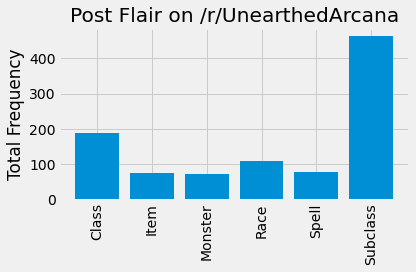

In [10]:
flair_labels, flair_counts = np.unique(ua_df["flair"].values, return_counts=True)
plt.figure(1)
plt.bar(flair_labels, flair_counts)
plt.title("Post Flair on /r/UnearthedArcana")
plt.ylabel("Total Frequency")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("ua_flair_frequency_bar2.png")

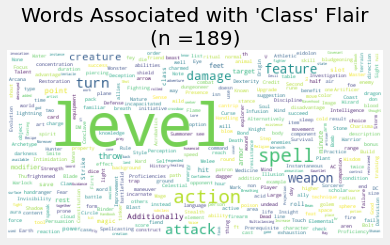

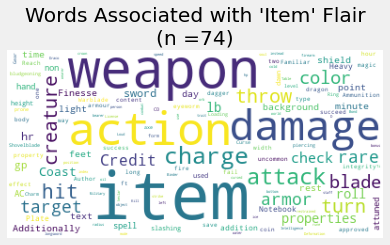

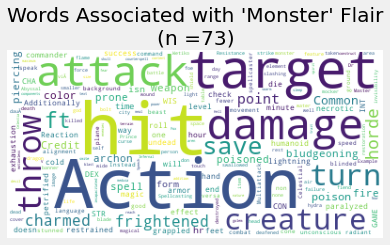

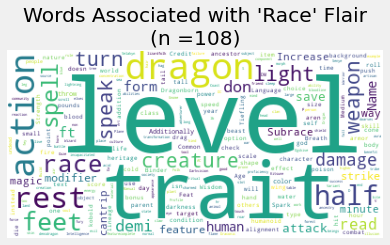

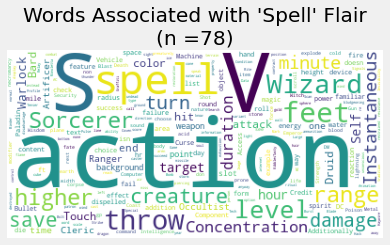

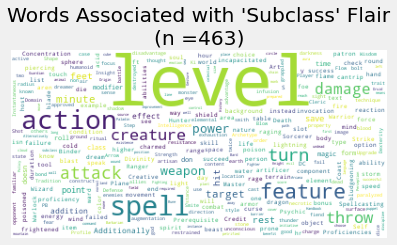

In [11]:
from wordcloud import WordCloud

for i,c in enumerate(["Class", "Item", "Monster", "Race", "Spell", "Subclass"]):
    documents = ua_df.loc[ua_df['flair'] == c]
    documents = documents['Text'].values
    num_docs = documents.shape[0]
    documents = documents.tolist()
    documents = [i.split() for i in documents]
    documents = [word for wordlist in documents for word in wordlist]
    documents = [i for i in documents if i.isalpha()]
    wordcloud = WordCloud(background_color="white",max_words=len(documents),relative_scaling=1, collocations=False).generate(' '.join(documents))
    plt.figure(i)
    plt.imshow(wordcloud)
    plt.title(f"Words Associated with '{c}' Flair\n(n ={num_docs})")
    plt.axis("off")
    plt.savefig(f"{c}_wordloud.png")

In [12]:
corpus = ua_df['Text']

vectorizer = CountVectorizer(strip_accents='unicode',ngram_range=(1,2))

X = vectorizer.fit_transform(corpus)
dtm = pd.DataFrame(X.todense(), columns=vectorizer.get_feature_names())

dtm = dtm[[i for i in dtm.columns if i.isalpha()]]
dtm = dtm[dtm.columns[dtm.sum() >= 5]]
print(dtm.shape[1])

pca = PCA(n_components=0.99, svd_solver='full')
princ_comps = pca.fit_transform(dtm)
dtm = pd.DataFrame(data=princ_comps)
print(dtm.shape[1])

5700
301


In [13]:
train_features = dtm.loc[ua_df['Split'].values == 'Train']
test_features = dtm.loc[ua_df['Split'].values == 'Test']
train_labels = ua_df.loc[ua_df['Split'] == 'Train']['flair']
test_labels = ua_df.loc[ua_df['Split'] == 'Test']['flair']

print(train_features.shape[0])
print(train_labels.shape[0])
print(test_features.shape[0])
print(test_labels.shape[0])

697
697
288
288


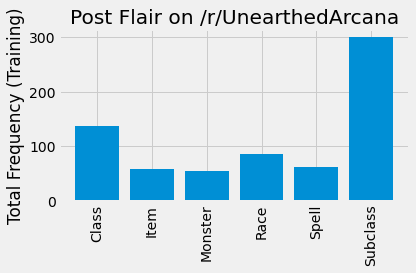

In [14]:
flair_labels, flair_counts = np.unique(train_labels.values, return_counts=True)
plt.figure(0)
plt.bar(flair_labels, flair_counts)
plt.title("Post Flair on /r/UnearthedArcana")
plt.ylabel("Total Frequency (Training)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("ua_flair_frequency_bar3.png")

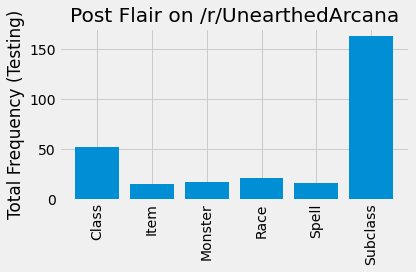

In [15]:
flair_labels, flair_counts = np.unique(test_labels.values, return_counts=True)
plt.figure(1)
plt.bar(flair_labels, flair_counts)
plt.title("Post Flair on /r/UnearthedArcana")
plt.ylabel("Total Frequency (Testing)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("ua_flair_frequency_bar4.png")

In [16]:
model = OneVsRestClassifier(SVC(class_weight='balanced'))

In [17]:
model.fit(train_features, train_labels)
train_predictions = model.predict(train_features)
test_predictions = model.predict(test_features)

In [18]:
for i in ["Class", "Item", "Monster", "Race", "Spell", "Subclass"]:
    cm = confusion_matrix(train_labels, train_predictions)
    cm = cm.astype('float') / cm.sum(axis=1)
    print(cm.diagonal())

[0.83941606 0.98275862 0.85454545 0.72093023 0.86885246 0.87333333]
[0.83941606 0.98275862 0.85454545 0.72093023 0.86885246 0.87333333]
[0.83941606 0.98275862 0.85454545 0.72093023 0.86885246 0.87333333]
[0.83941606 0.98275862 0.85454545 0.72093023 0.86885246 0.87333333]
[0.83941606 0.98275862 0.85454545 0.72093023 0.86885246 0.87333333]
[0.83941606 0.98275862 0.85454545 0.72093023 0.86885246 0.87333333]


In [19]:
for i in ["Class", "Item", "Monster", "Race", "Spell", "Subclass"]:
    cm = confusion_matrix(test_labels, test_predictions)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm.diagonal())

[0.82692308 0.9375     0.83333333 0.86363636 0.58823529 0.89570552]
[0.82692308 0.9375     0.83333333 0.86363636 0.58823529 0.89570552]
[0.82692308 0.9375     0.83333333 0.86363636 0.58823529 0.89570552]
[0.82692308 0.9375     0.83333333 0.86363636 0.58823529 0.89570552]
[0.82692308 0.9375     0.83333333 0.86363636 0.58823529 0.89570552]
[0.82692308 0.9375     0.83333333 0.86363636 0.58823529 0.89570552]


In [20]:
prec, recall, fscore, support = precision_recall_fscore_support(test_labels, test_predictions)
accuracy = accuracy_score(test_labels, test_predictions)

print(accuracy)
print(prec)
print(recall)
print(fscore)
print(support)

0.8611111111111112
[0.81132075 0.46875    0.78947368 1.         0.83333333 0.95424837]
[0.82692308 0.9375     0.83333333 0.86363636 0.58823529 0.89570552]
[0.81904762 0.625      0.81081081 0.92682927 0.68965517 0.92405063]
[ 52  16  18  22  17 163]
